## Import packages

In [1]:
import numpy as np
import simulators.jla_supernovae.jla_simulator as jla
import pydelfi.ndes as ndes
import pydelfi.delfi_edit as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
import pylab as plt
import pyccl as ccl
import scipy
from scipy.interpolate import interp1d

import matplotlib
%matplotlib inline

import time
import importlib

print("CCL version you are using:",ccl.__version__)

CCL version you are using: 2.1.0


In [3]:
font_config = {"size" : 14,
               "family" : "serif"}

matplotlib.rc("font", **font_config)
matplotlib.rc("text", usetex=True)
# Move title to make space for exponents of y axis
matplotlib.rc("axes", titlepad=5) 
matplotlib.rc("axes", titlesize="medium") 

# Make the figures bigger in the notebook
matplotlib.rc("figure")#, dpi=150)

color_map = plt.get_cmap("tab10")

paper_textwidth = 7.125
fig_size = (paper_textwidth, 2.6)

plot_adjust = dict(left=0.2, top=0.9, bottom=0.2)

In [4]:
import matplotlib.pyplot as plt

In [5]:
import simulators.mass_function_n_counts.simulator_trapz_tinker_2params as n_counts_simulator
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_tinker_2params' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_tinker_2params.py'>

In [6]:
log10masses = np.linspace(14, 15.5, num = 2)
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)
log10masses_2d = np.stack((log10masses[:-1], log10masses[1:]))

In [7]:
lower = np.array([0.1125, 0.65])
upper = np.array([0.1275, 0.85])
prior = priors.Uniform(lower, upper)

In [8]:
theta_fiducial = np.array([0.1197, 0.76])
mass_calibration_param_names = ['\\alpha_{Y}', '\\beta_{Y}', '\\gamma_{Y}', 'Y_{*}', 'M_{*}', 
                                '\\alpha_{\sigma}', '\\gamma_{\sigma}', '\\sigma_{log Y_{0}}']

theta_fiducial_mass_calibration = np.array([1.8, 0., 0., 2.4e-10, 1e14, 0., 0., 0.127])

In [9]:
theta_fiducial_total = np.concatenate((theta_fiducial, theta_fiducial_mass_calibration))

In [10]:
N_countsSimulator = n_counts_simulator.Model(log10masses, z_min, z_max)
N_counts = N_countsSimulator.N_counts
#N_counts = N_countsSimulator.simulation(theta_fiducial, 1)
N_counts

array([22926.84511865, 68010.58076614, 85143.87570284, 74152.91292208,
       51774.03079771])

In [11]:
t1 = time.process_time()
N_countsSimulator.simulation(theta_fiducial, 1)
t2 = time.process_time()
print('time per 1 sim: '+ str(t2-t1))

time per 1 sim: 0.31425264099999994


## Version 1

(1) Compute fiducial number of counts N for redshift bins (for a range of masses, 14 to 15.5)

(2) Draw N samples from uniformly distributed redshift bins

(3) Draw masses for every redshift

(4) Create mock catalogue

In [12]:
import simulators.mass_function_n_counts.simulator_trapz_tinker_2params_mock_catalogue_v1_Y500 as n_counts_simulator_1

In [13]:
importlib.reload(n_counts_simulator_1)

<module 'simulators.mass_function_n_counts.simulator_trapz_tinker_2params_mock_catalogue_v1_Y500' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_tinker_2params_mock_catalogue_v1_Y500.py'>

In [14]:
N_countsSimulator1 = n_counts_simulator_1.Model(log10masses, z_min, z_max)

In [15]:
N_countsSimulator1.N_counts

(array([ 7487.26774769, 22519.00909962, 27996.24759731, 23465.767297  ,
        15226.37143005]),
 pyccl.Cosmology(Omega_c=0.25141776937618154, Omega_b=0.04667086746481833, h=0.69, n_s=0.9655, sigma8=0.76, A_s=None, Omega_k=0, Omega_g=0, Neff=0, w0=-1, wa=0, T_CMB=2.7, bcm_log10Mc=14.079181246047625, bcm_etab=0.5, bcm_ks=55.0, mu_0=0.0, sigma_0=0.0, m_nu=0.0, m_nu_type=None, z_mg=None, df_mg=None, transfer_function='bbks', matter_power_spectrum='halofit', baryons_power_spectrum='nobaryons', mass_function='tinker', halo_concentration='duffy2008', emulator_neutrinos='strict'))

In [16]:
t1 = time.process_time()
Y_500_1 = N_countsSimulator1.simulation(theta_fiducial_total, 1)
t2 = time.process_time()
print('time per 1 sim: ' + str(t2 - t1))

time per 1 sim: 1.9650421399999995


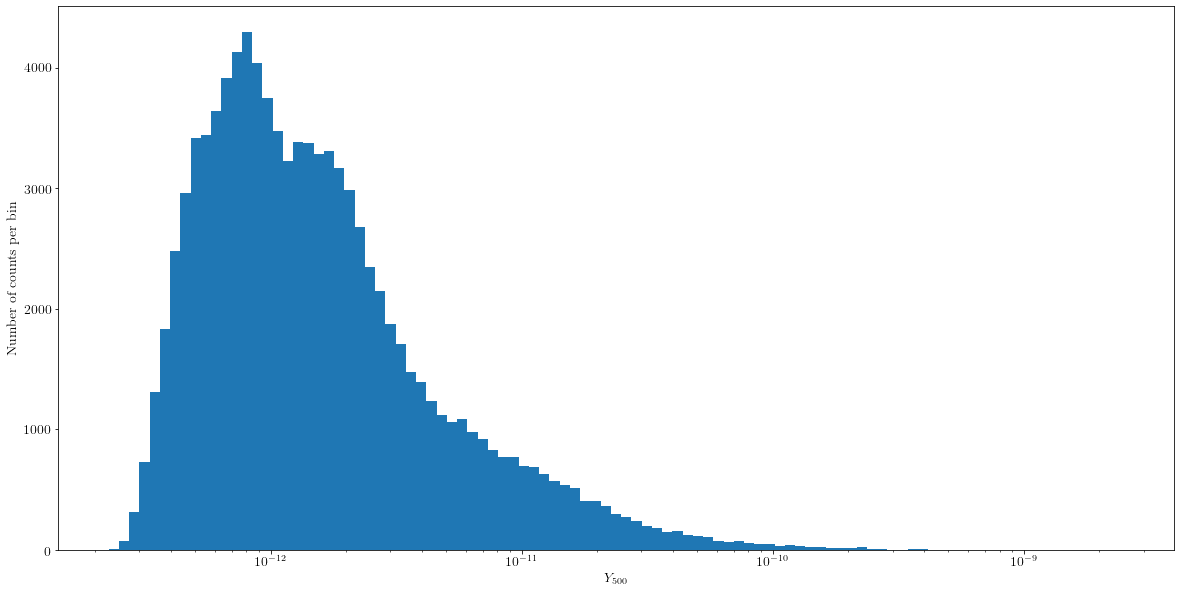

In [17]:
plt.figure(figsize=(20,10))
plt.hist(Y_500_1, bins=np.logspace(np.log10(np.amin(Y_500_1)), np.log10(np.amax(Y_500_1)), 100))
plt.gca().set_xscale("log")
plt.xlabel(r'$Y_{500}$')
plt.ylabel('Number of counts per bin')
plt.show()

## Version 2

(1) Compute fiducial number of counts N for different redshift bins (for a range of masses, 14 to 15.5)

(2) Draw N samples from joint redshift-mass distribution

(3) Create mock catalogue

In [18]:
import simulators.mass_function_n_counts.simulator_trapz_tinker_2params_mock_catalogue_v2_Y500 as n_counts_simulator_2

In [19]:
importlib.reload(n_counts_simulator_2)

<module 'simulators.mass_function_n_counts.simulator_trapz_tinker_2params_mock_catalogue_v2_Y500' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_tinker_2params_mock_catalogue_v2_Y500.py'>

In [20]:
N_countsSimulator2 = n_counts_simulator_2.Model(log10masses, z_min, z_max)

In [21]:
N_countsSimulator2.N_counts

(array([ 7487.26774769, 22519.00909962, 27996.24759731, 23465.767297  ,
        15226.37143005]),
 pyccl.Cosmology(Omega_c=0.25141776937618154, Omega_b=0.04667086746481833, h=0.69, n_s=0.9655, sigma8=0.76, A_s=None, Omega_k=0, Omega_g=0, Neff=0, w0=-1, wa=0, T_CMB=2.7, bcm_log10Mc=14.079181246047625, bcm_etab=0.5, bcm_ks=55.0, mu_0=0.0, sigma_0=0.0, m_nu=0.0, m_nu_type=None, z_mg=None, df_mg=None, transfer_function='bbks', matter_power_spectrum='halofit', baryons_power_spectrum='nobaryons', mass_function='tinker', halo_concentration='duffy2008', emulator_neutrinos='strict'))

In [22]:
t1 = time.process_time()
Y_500_2 = N_countsSimulator2.simulation(theta_fiducial_total, 1)
t2 = time.process_time()
print('time per 1 sim: ' + str(t2 -t1))

time per 1 sim: 21.920995298


In [23]:
Y_500_2

array([7.71453826e-12, 7.45368520e-12, 1.44119413e-11, ...,
       3.43810943e-13, 1.39468319e-12, 4.90227954e-13])

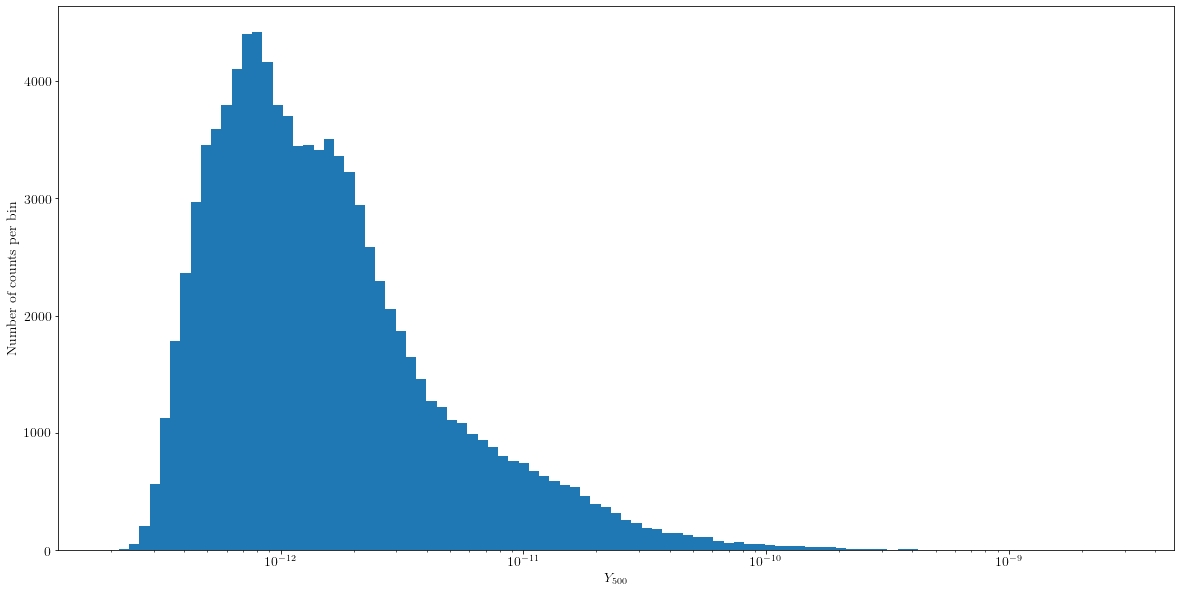

In [24]:
plt.figure(figsize=(20,10))
plt.hist(Y_500_2, bins=np.logspace(np.log10(np.amin(Y_500_2)), np.log10(np.amax(Y_500_2)), 100))
plt.gca().set_xscale("log")
plt.xlabel(r'$Y_{500}$')
plt.ylabel('Number of counts per bin')
plt.show()

In [25]:
Y_500_1.shape

(96253,)

In [26]:
Y_500_2.shape

(96253,)

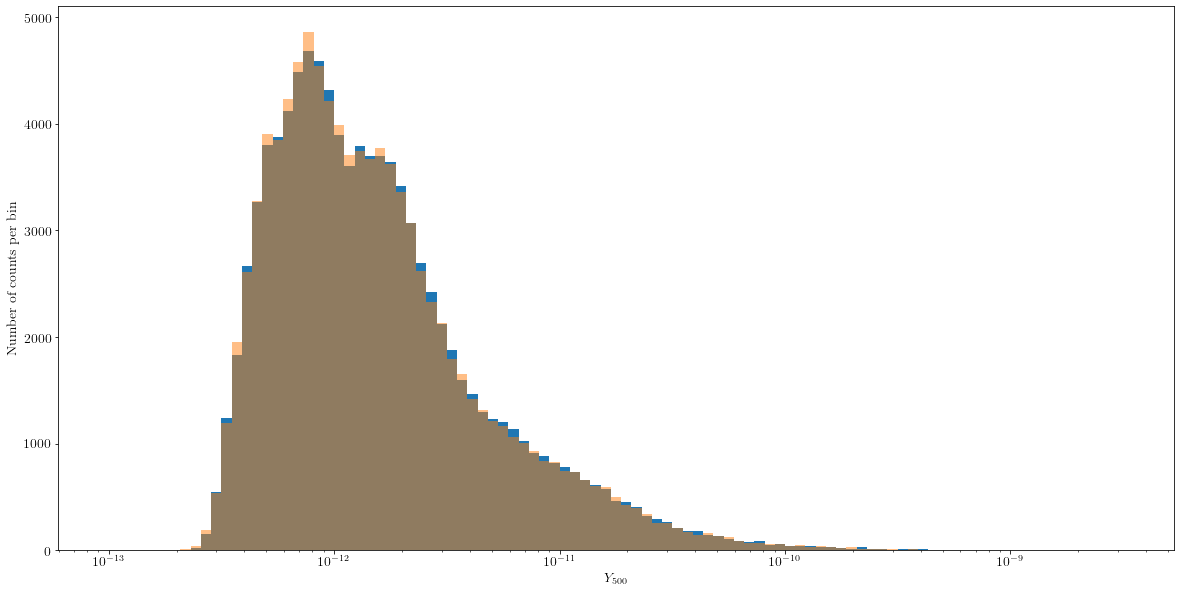

In [27]:
plt.figure(figsize=(20,10))
plt.hist(Y_500_1, bins=np.logspace(-13, -8.5, 100))
plt.hist(Y_500_2, bins=np.logspace(-13, -8.5, 100), alpha = 0.5)
plt.gca().set_xscale("log")
plt.xlabel(r'$Y_{500}$')
plt.ylabel('Number of counts per bin')
plt.show()

In [28]:
np.log10(np.amax(Y_500_2))

-8.529646924128304

In [29]:
np.log10(np.amax(Y_500_1))

-8.676834824415725

In [30]:
np.logspace(np.log10(3.1e-12), np.log10(1.8e-10), num = 15)

array([3.10000000e-12, 4.14338532e-12, 5.53794901e-12, 7.40188924e-12,
       9.89318684e-12, 1.32229952e-11, 1.76735369e-11, 2.36220236e-11,
       3.15726277e-11, 4.21992136e-11, 5.64024524e-11, 7.53861591e-11,
       1.00759324e-10, 1.34672486e-10, 1.80000000e-10])

In [31]:
np.amin(Y_500_1)

1.8975630229689275e-13

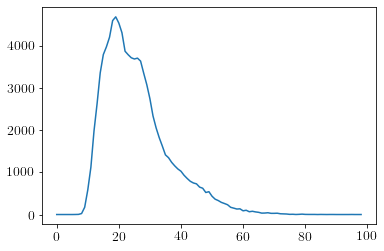

In [32]:
plt.plot(np.histogram(Y_500_1, bins=np.logspace(-13, -8.5, 100))[0])

In [221]:
np.histogram(Y_500_1, bins=np.logspace(-13, -8, 100))[0].shape

(99,)

In [28]:
seeds = np.linspace(1, 100, num = 100)


In [29]:
Y_500_1_arrays_c = []
for i in range(len(seeds)):
    Y_500_1_temp = N_countsSimulator1.simulation(theta_fiducial_total, i)
    Y_500_1_arrays_c.append(np.histogram(Y_500_1_temp, bins=np.logspace(-13, -8.5, 100))[0])
    if i%10 ==0:
        print(i)
        
Y_500_1_arrays_c = np.array(Y_500_1_arrays_c)
np.save('Y_500_1_arrays_c.npy', Y_500_1_arrays_c)

0
10
20
30
40
50
60
70
80
90


In [222]:
Y_500_1_arrays = []
for i in range(len(seeds)):
    Y_500_1_temp = N_countsSimulator1.simulation(theta_fiducial_total, i)
    Y_500_1_arrays.append(np.histogram(Y_500_1_temp, bins=np.logspace(-13, -8.5, 100))[0])
    if i%10 ==0:
        print(i)
        
Y_500_1_arrays = np.array(Y_500_1_arrays)
np.save('Y_500_1_arrays.npy', Y_500_1_arrays)

0
10
20
30
40
50
60
70
80
90


TypeError: _save_dispatcher() missing 1 required positional argument: 'arr'

In [223]:
np.save('Y_500_1_arrays.npy', Y_500_1_arrays)

In [224]:
Y_500_2_arrays = []
for i in range(len(seeds)):
    Y_500_2_temp = N_countsSimulator2.simulation(theta_fiducial_total, i)
    Y_500_2_arrays.append(np.histogram(Y_500_2_temp, bins=np.logspace(-13, -8.5, 100))[0])
    if i%10 ==0:
        print(i)
        
Y_500_2_arrays = np.array(Y_500_2_arrays)
np.save('Y_500_2_arrays.npy',Y_500_2_arrays)

0
10
20
30
40
50
60
70
80
90


In [33]:
Y_500_1_arrays = np.load('Y_500_1_arrays.npy')
Y_500_2_arrays = np.load('Y_500_2_arrays.npy')

In [34]:
Y_500_1_arrays.shape

(100, 99)

/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


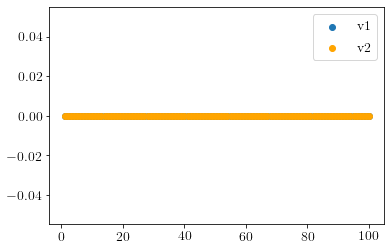

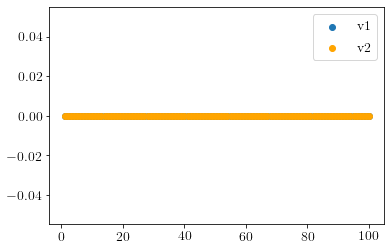

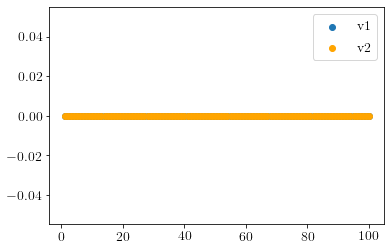

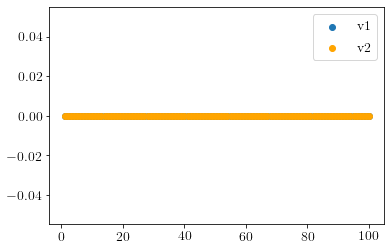

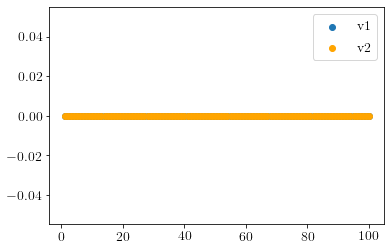

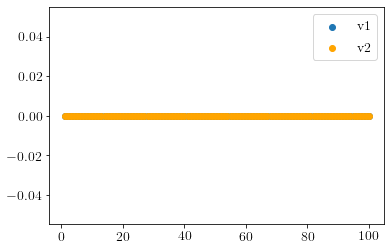

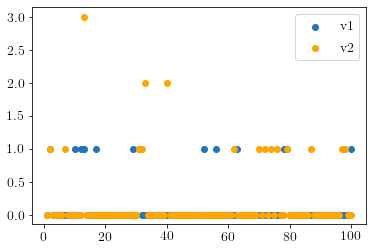

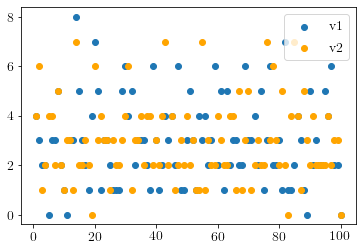

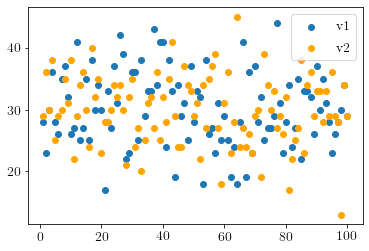

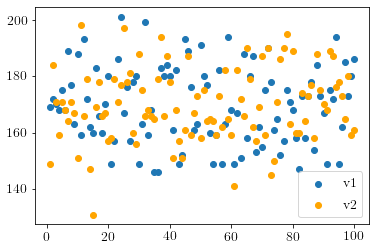

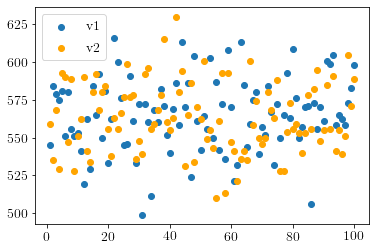

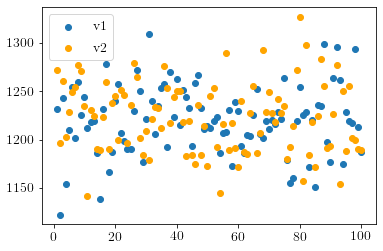

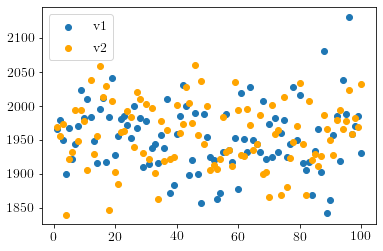

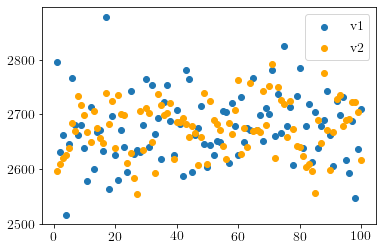

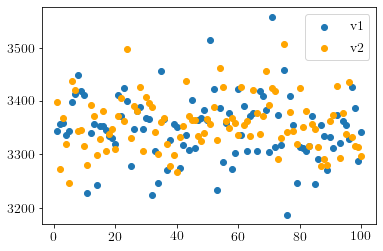

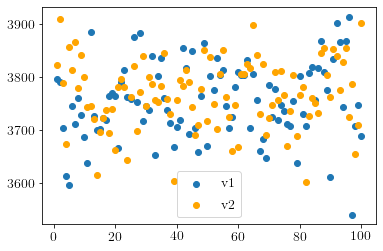

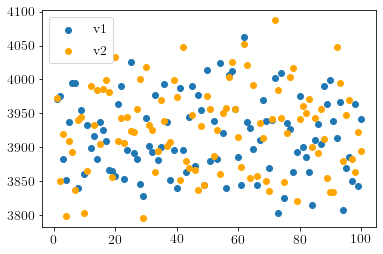

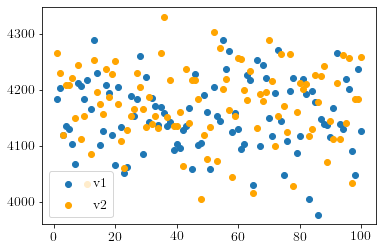

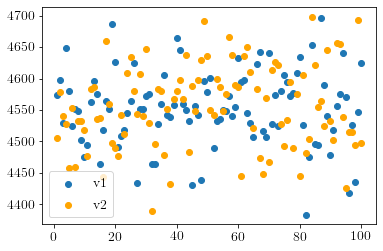

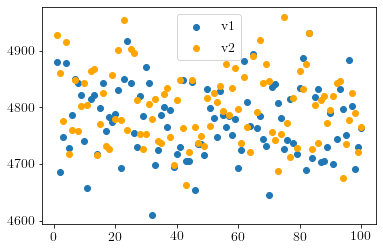

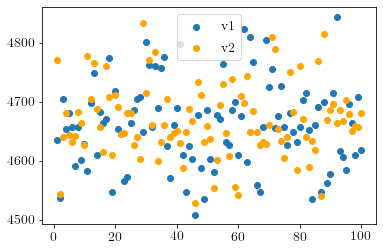

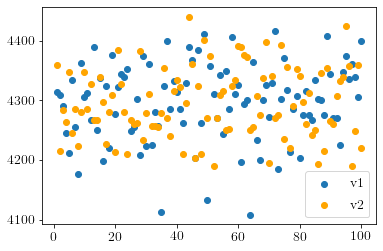

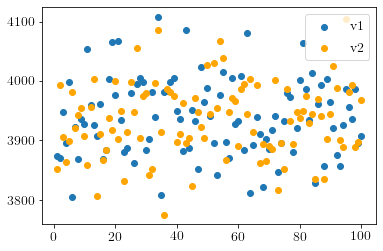

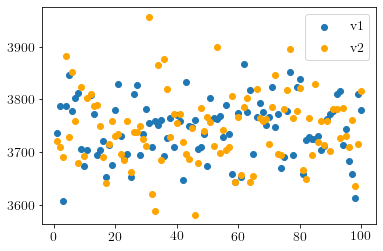

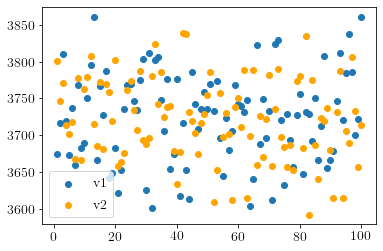

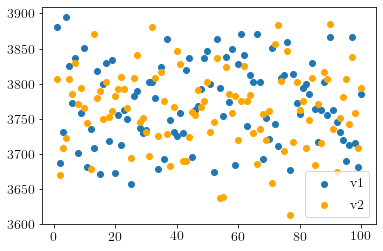

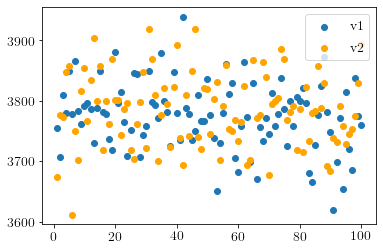

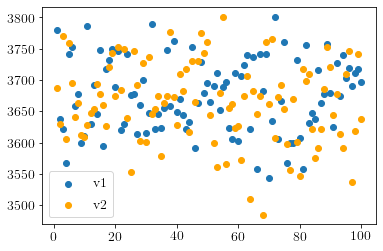

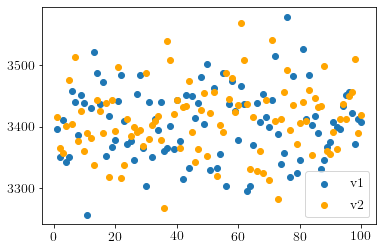

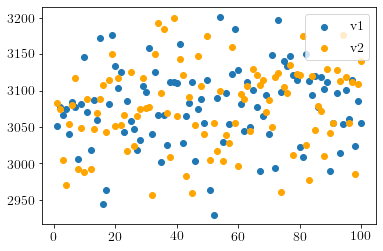

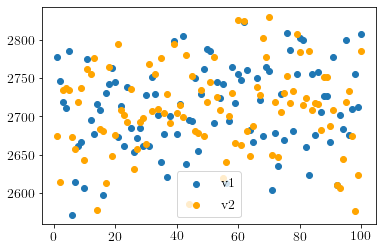

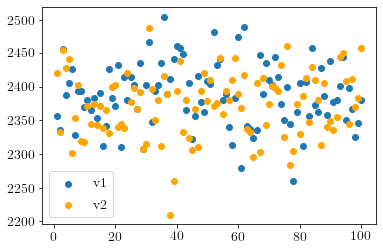

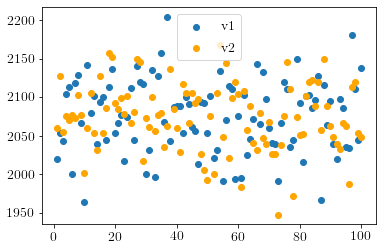

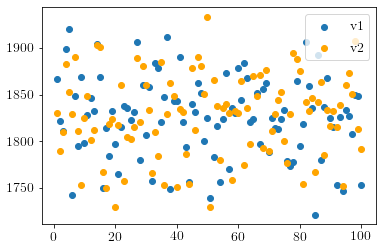

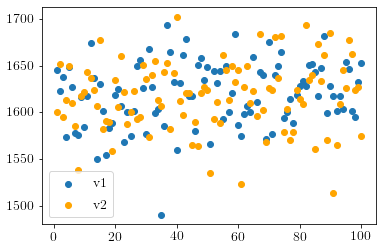

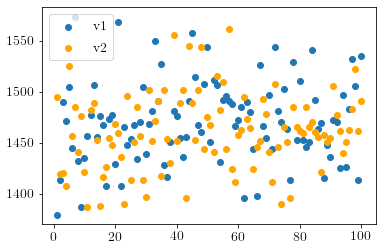

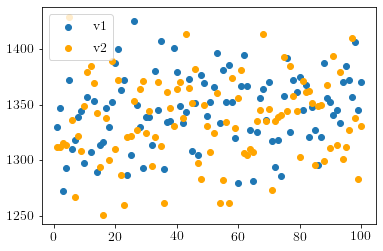

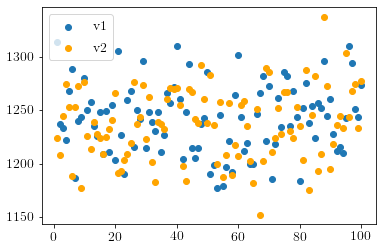

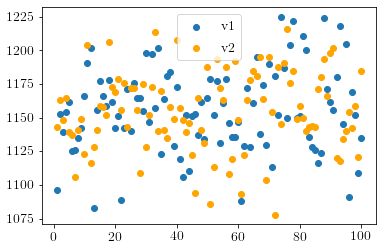

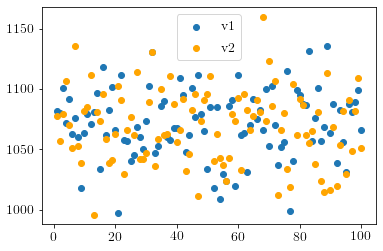

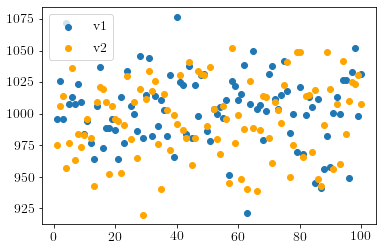

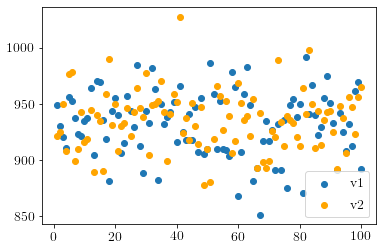

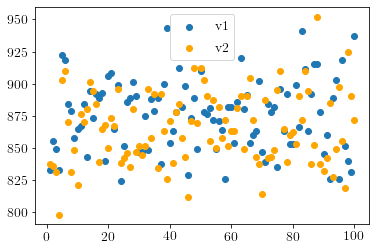

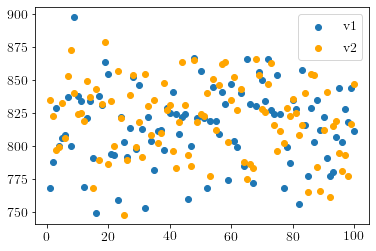

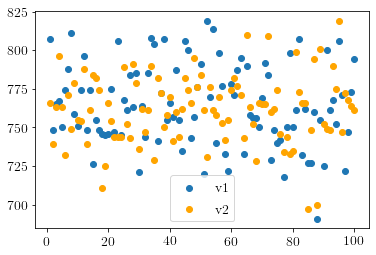

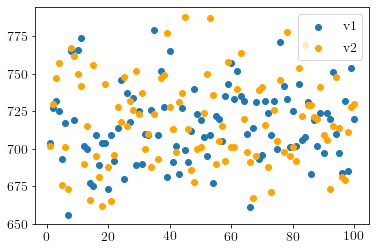

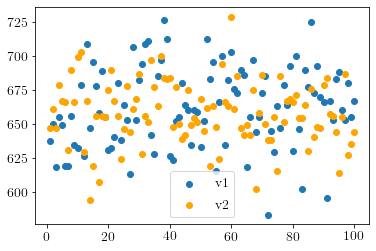

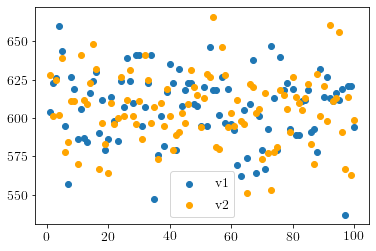

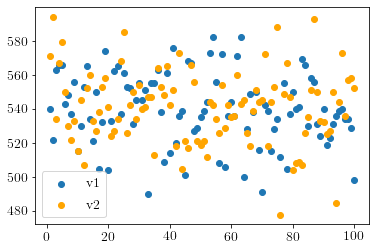

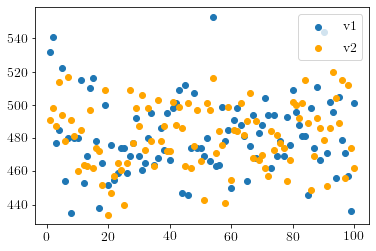

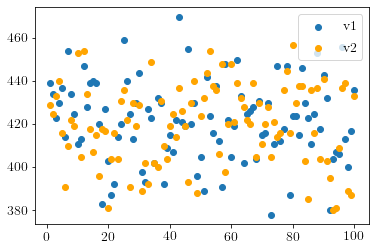

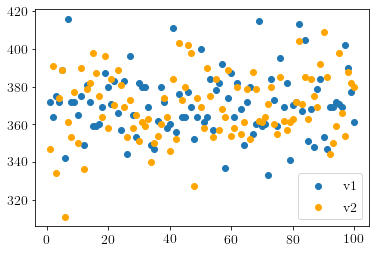

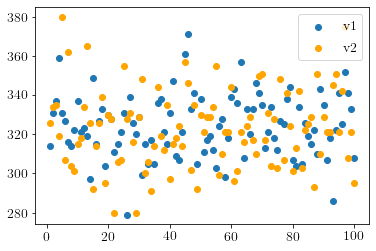

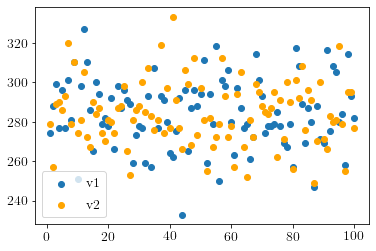

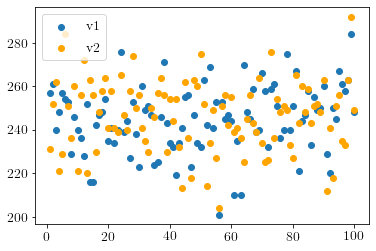

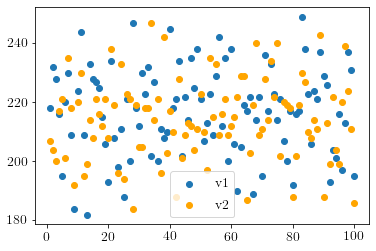

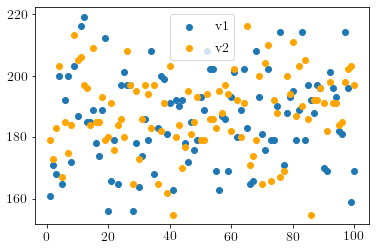

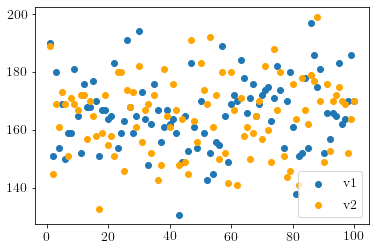

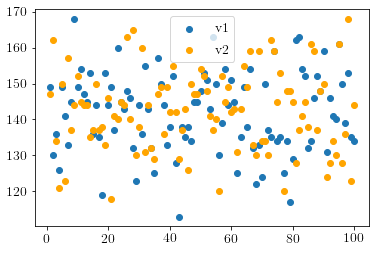

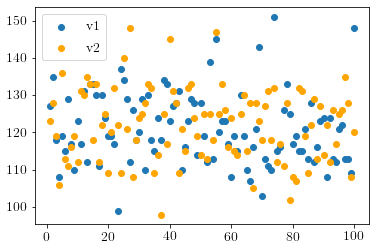

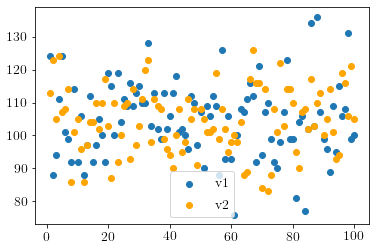

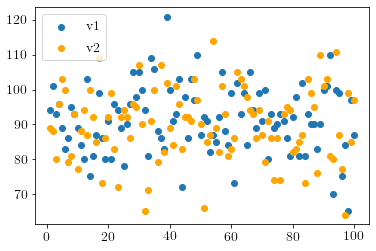

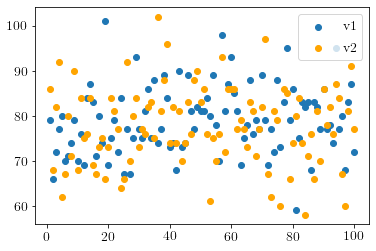

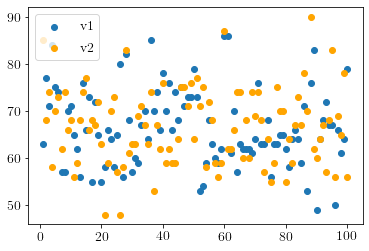

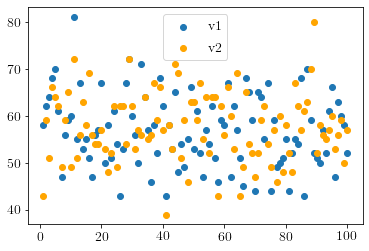

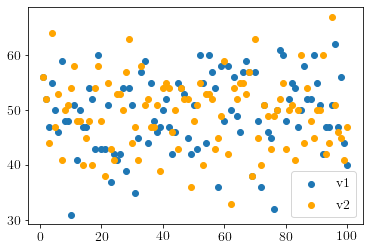

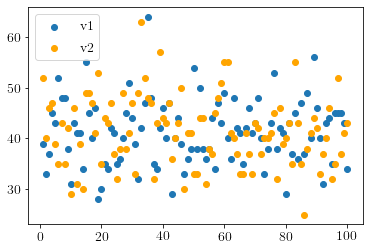

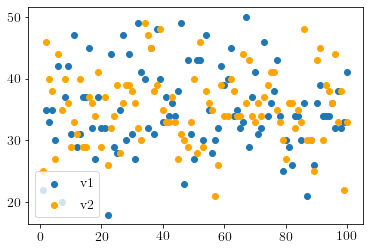

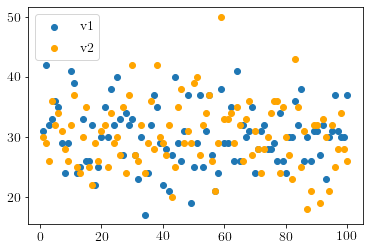

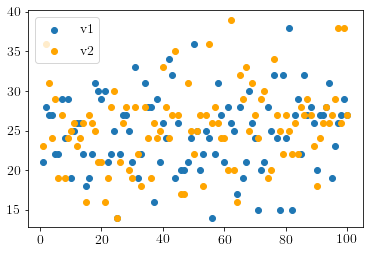

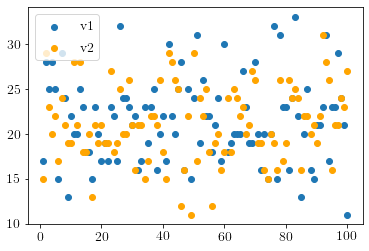

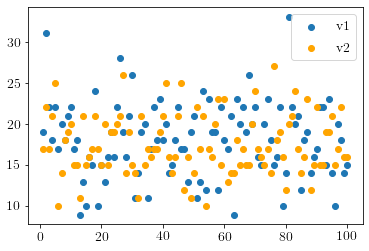

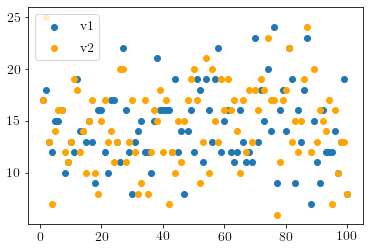

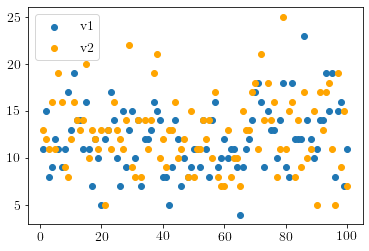

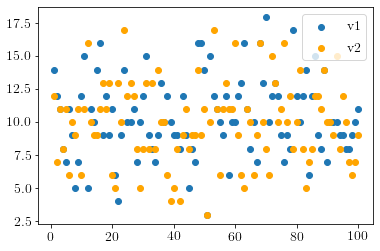

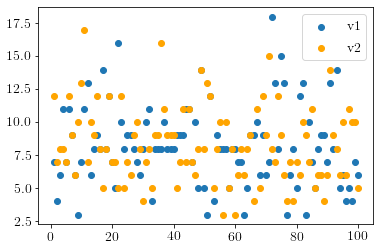

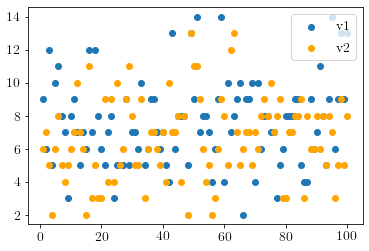

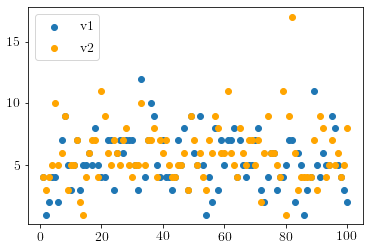

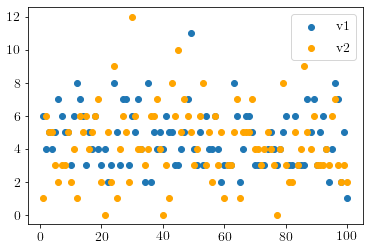

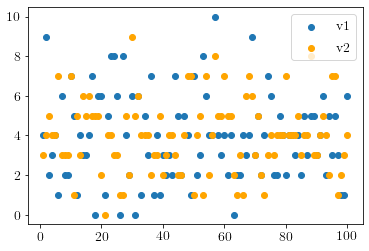

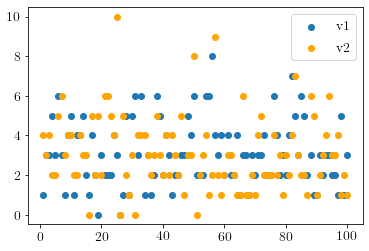

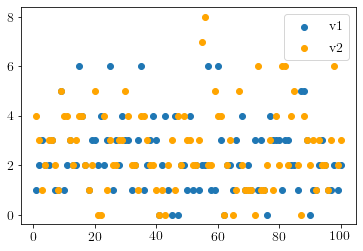

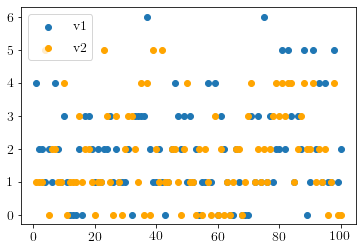

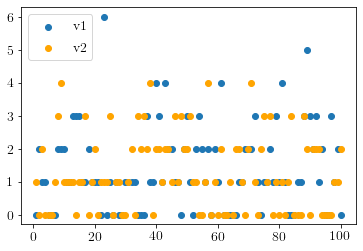

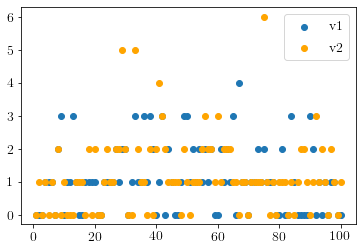

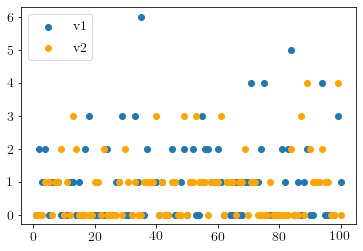

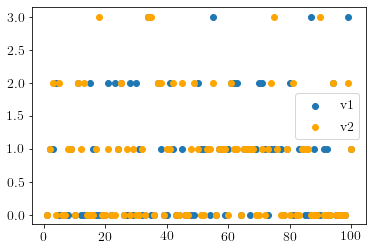

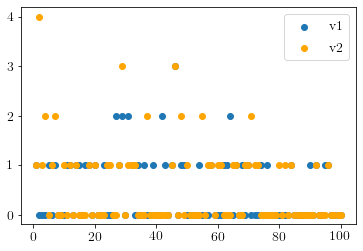

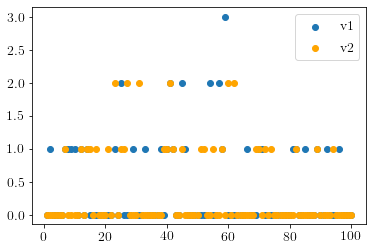

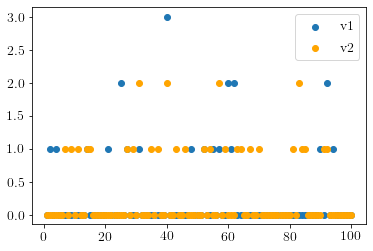

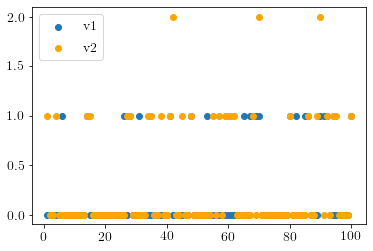

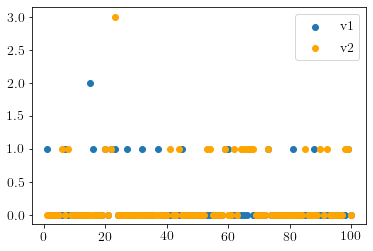

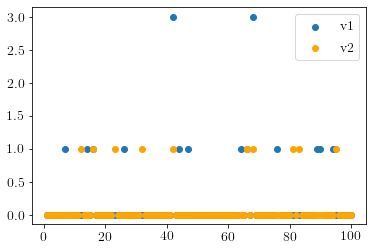

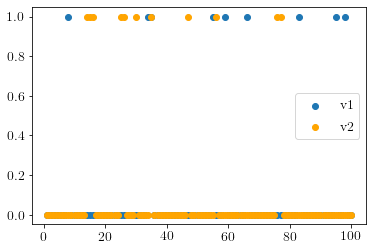

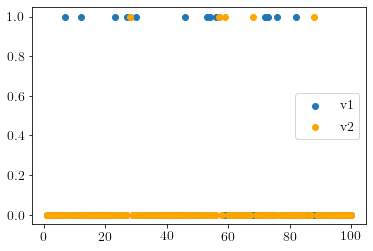

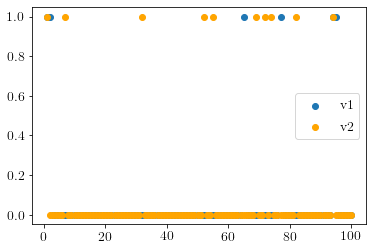

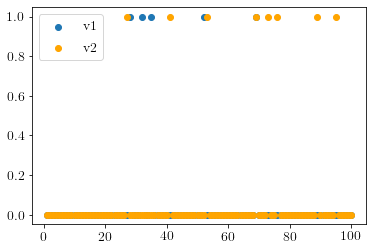

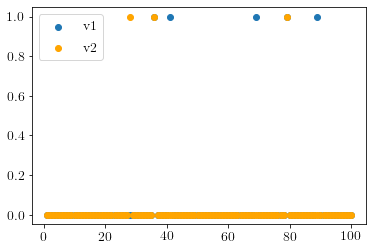

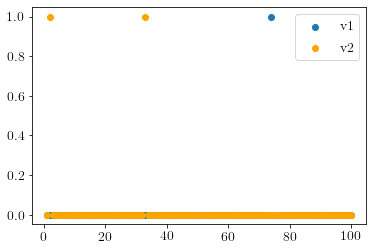

In [40]:
for i in range(Y_500_1_arrays.shape[1]):
    plt.figure()
    plt.scatter(seeds, Y_500_1_arrays[:, i], label = 'v1')
    plt.scatter(seeds, Y_500_2_arrays[:, i], label = 'v2', c = 'orange')
    plt.legend(loc = 'best')

In [37]:
seeds.shape

(100,)

In [31]:
Y_500_2_arrays = np.load('Y_500_2_arrays.npy')

/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


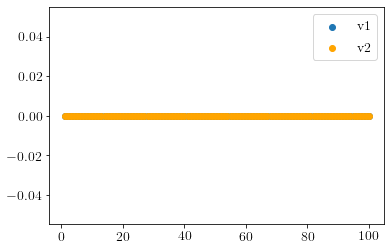

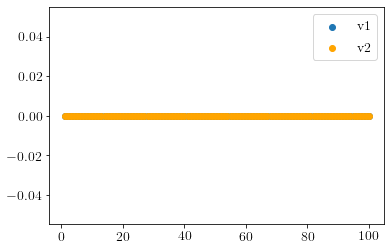

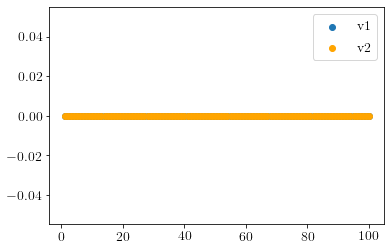

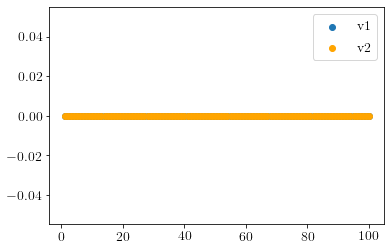

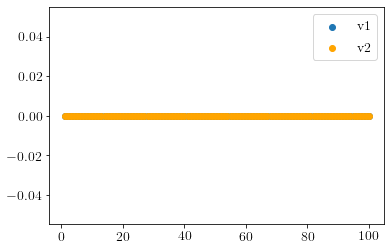

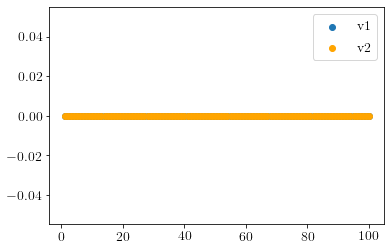

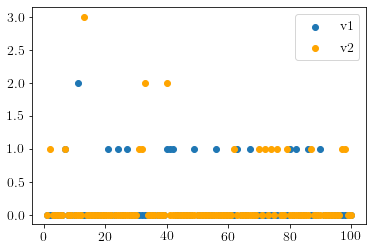

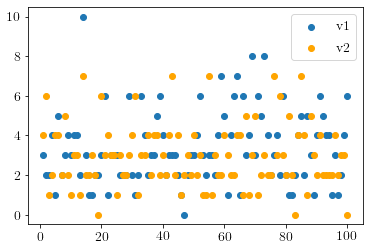

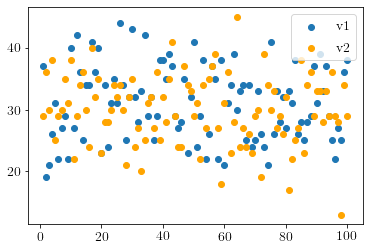

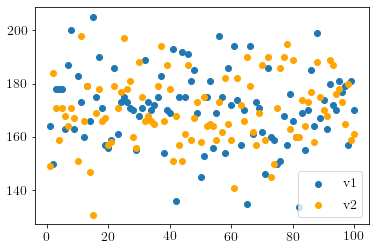

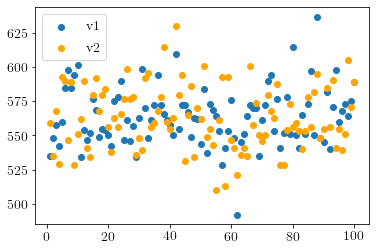

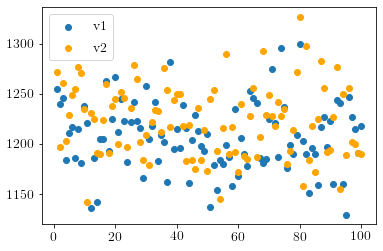

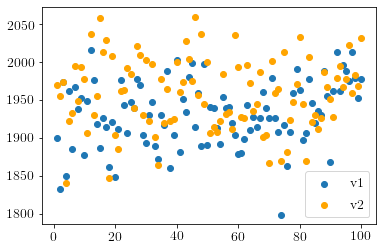

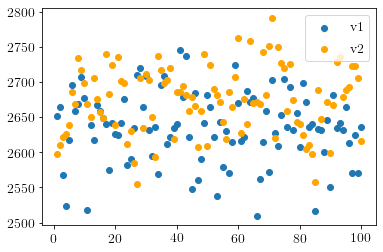

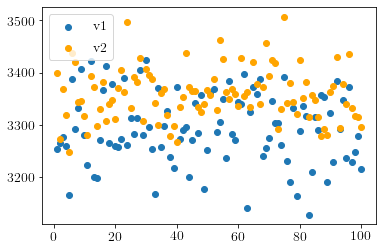

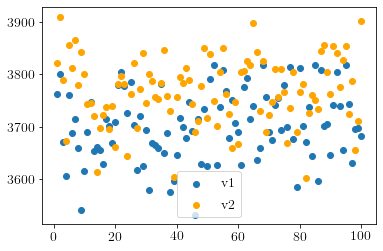

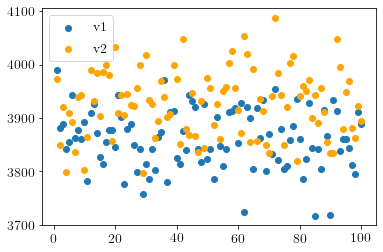

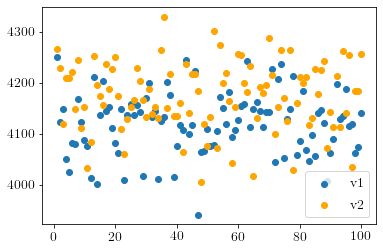

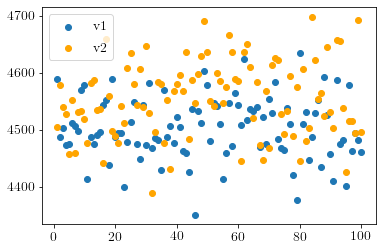

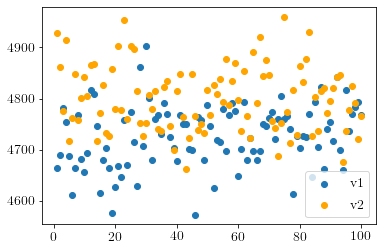

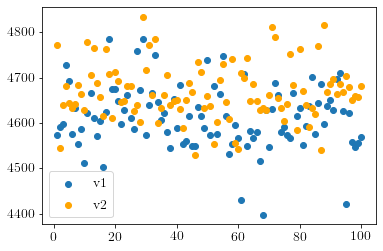

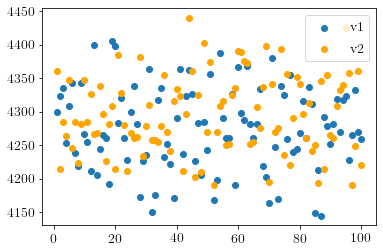

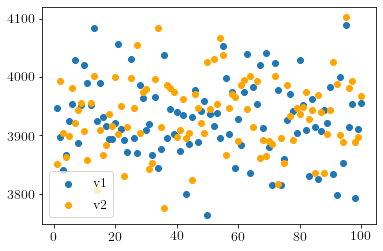

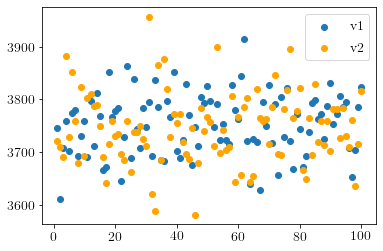

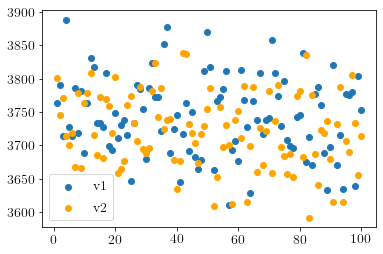

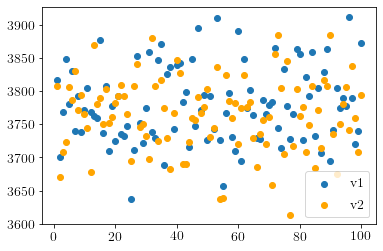

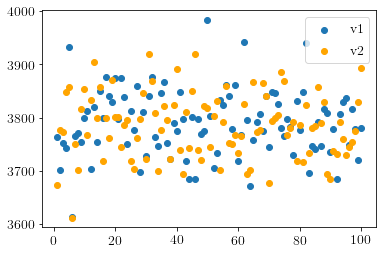

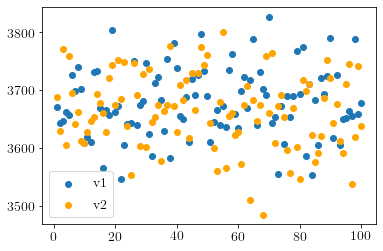

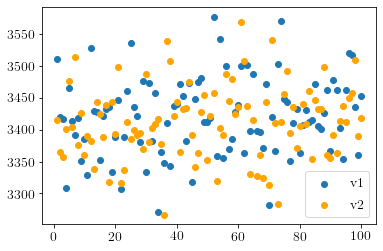

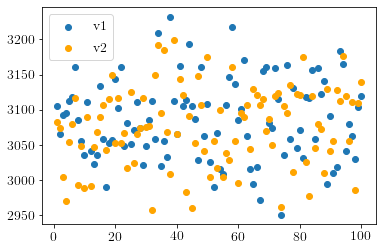

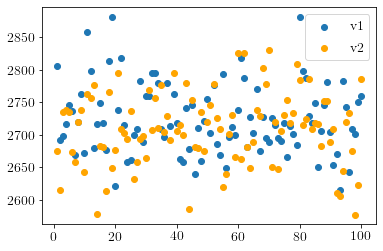

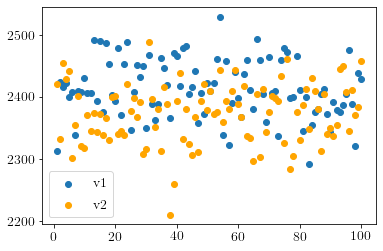

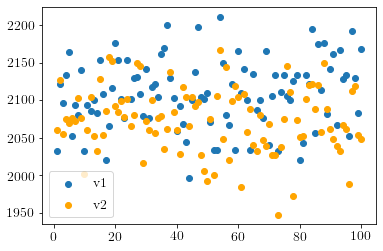

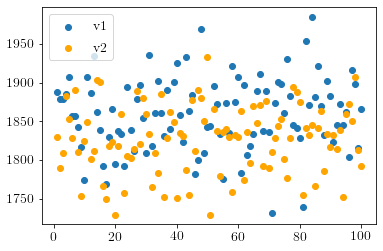

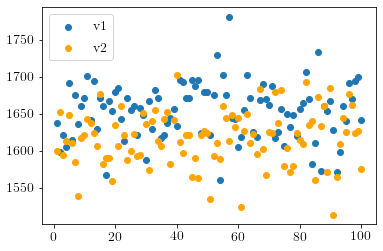

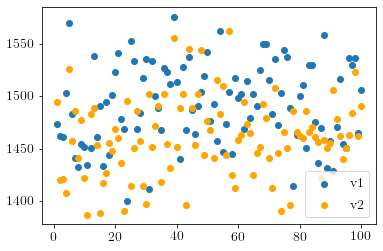

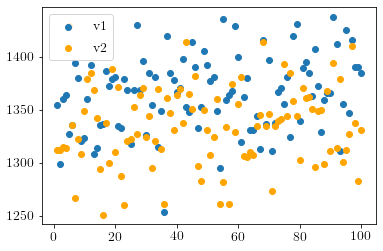

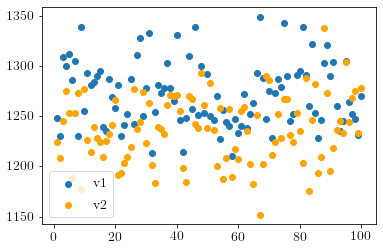

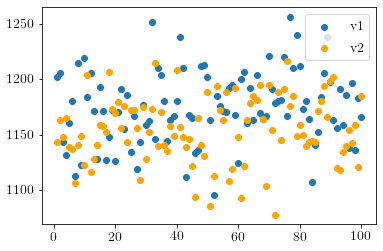

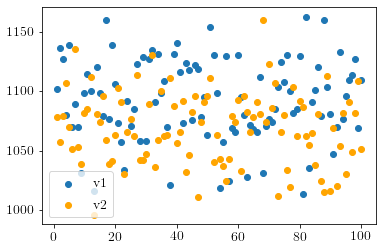

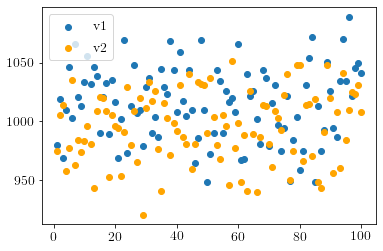

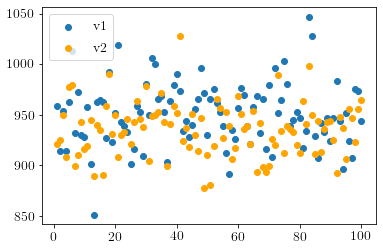

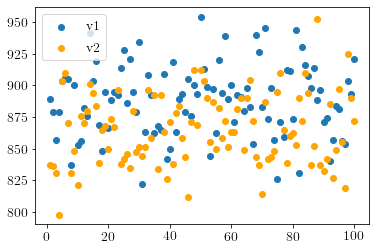

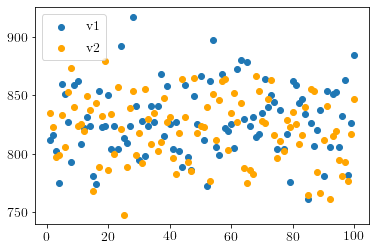

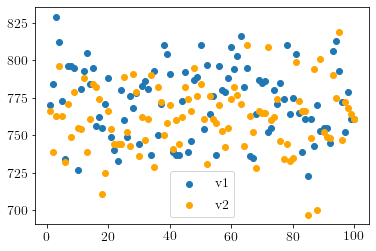

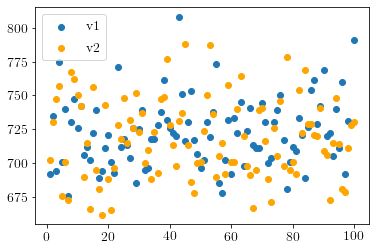

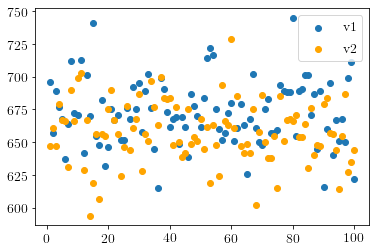

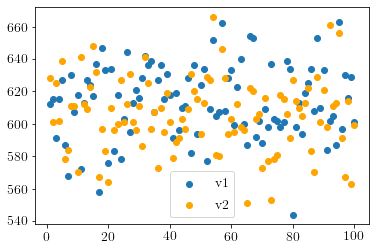

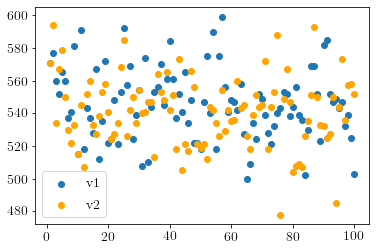

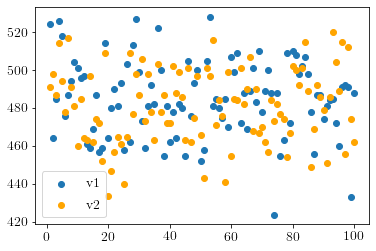

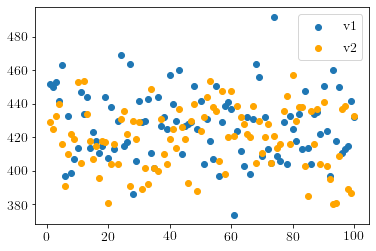

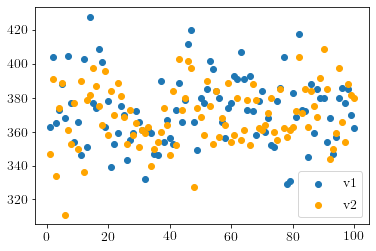

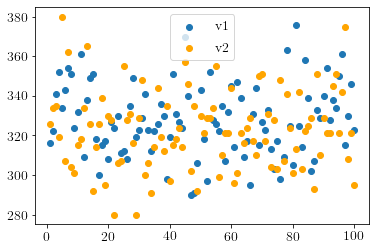

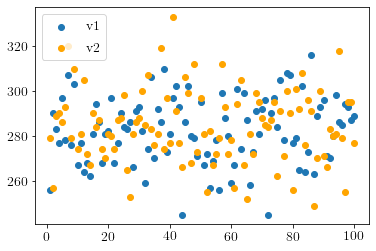

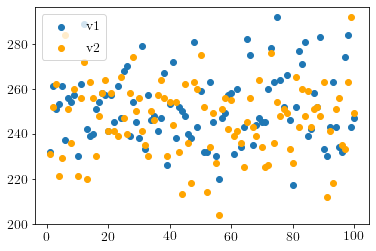

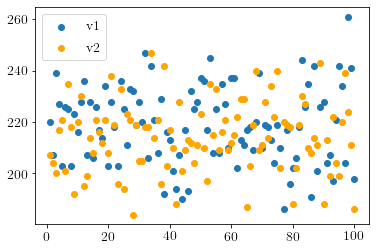

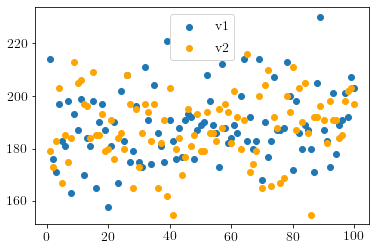

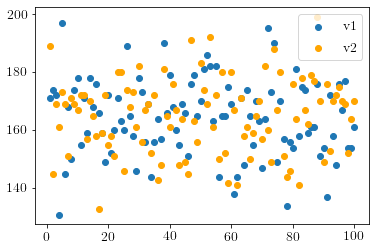

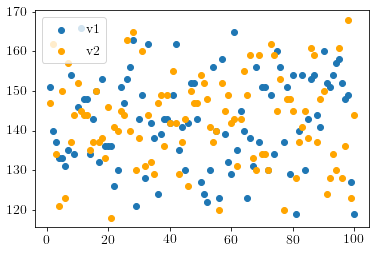

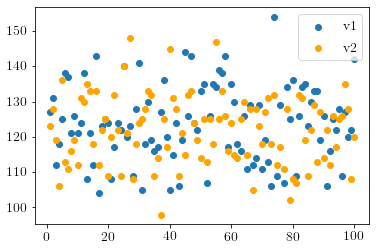

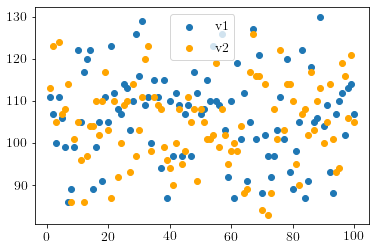

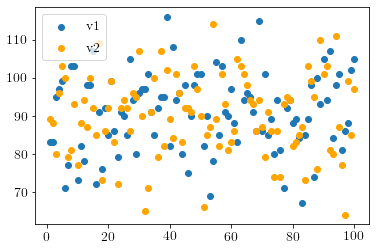

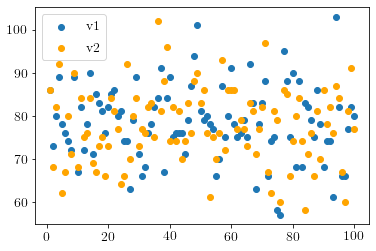

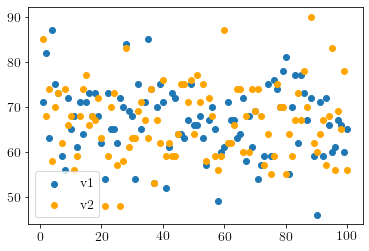

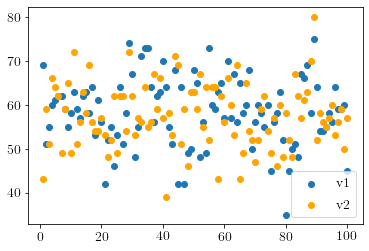

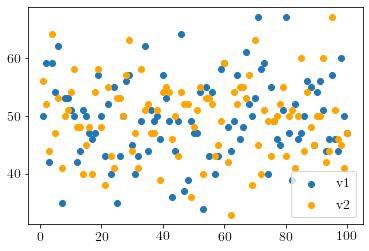

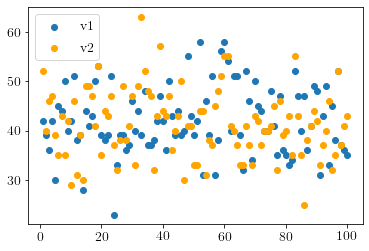

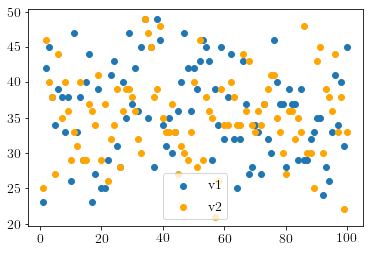

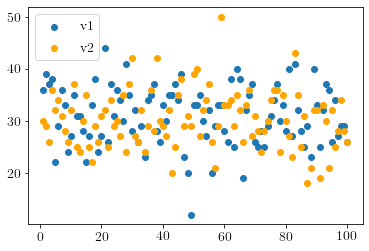

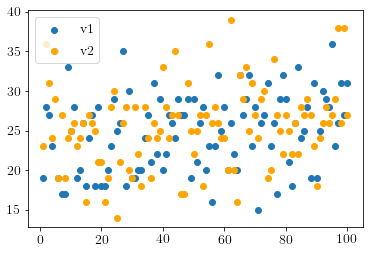

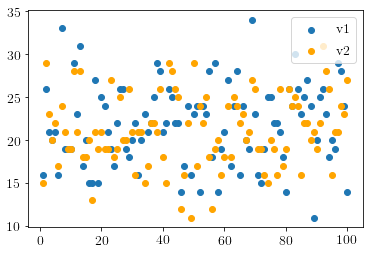

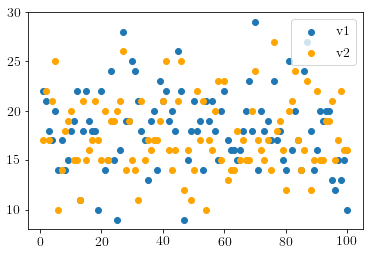

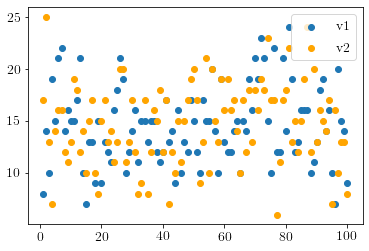

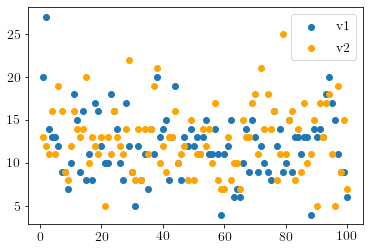

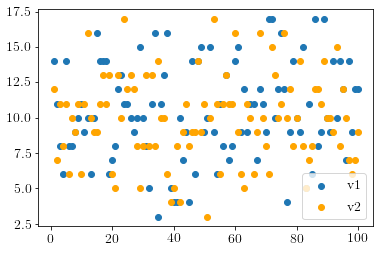

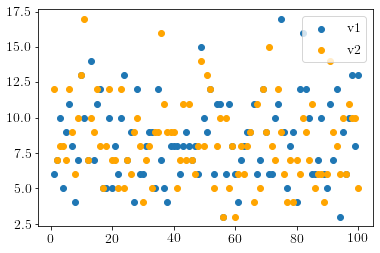

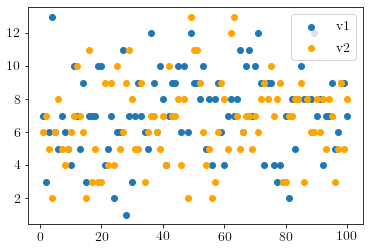

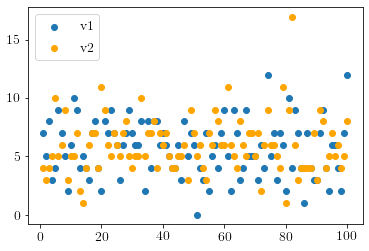

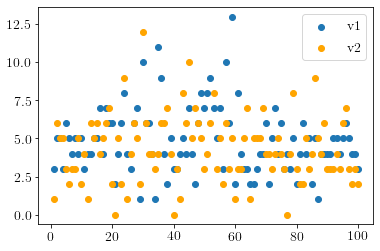

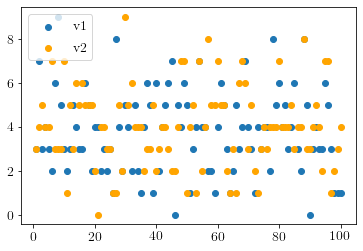

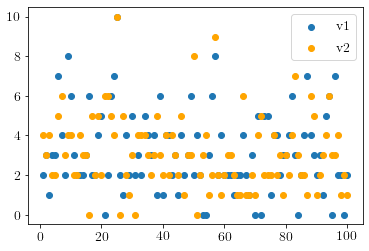

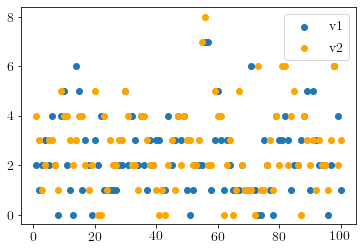

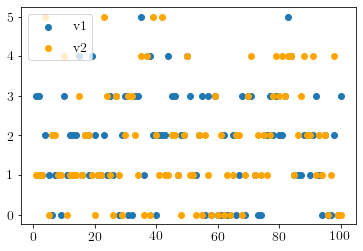

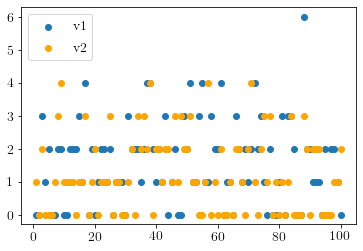

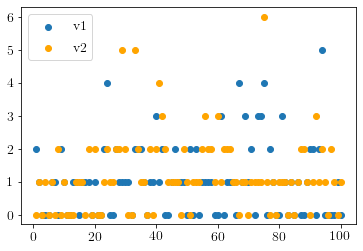

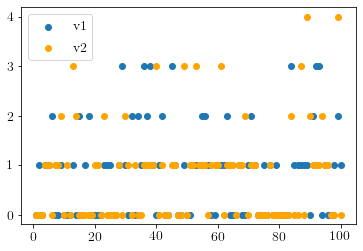

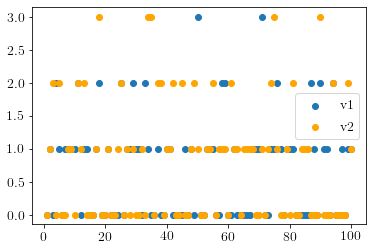

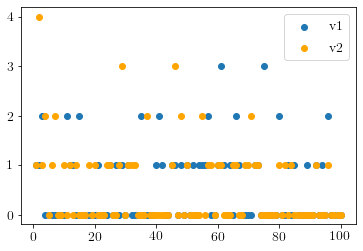

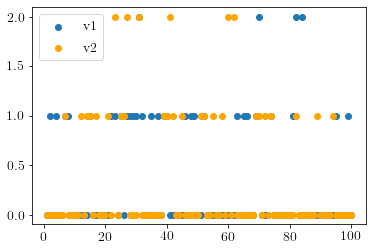

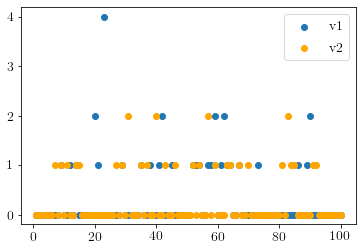

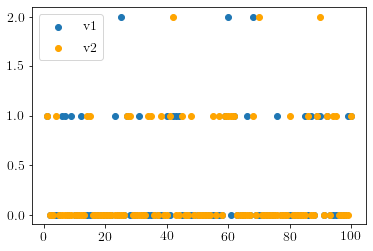

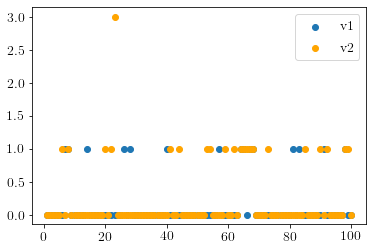

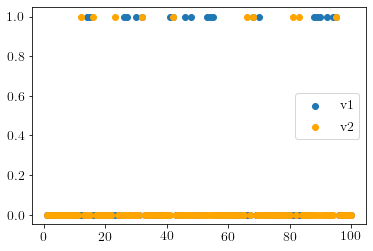

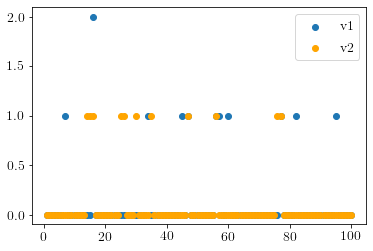

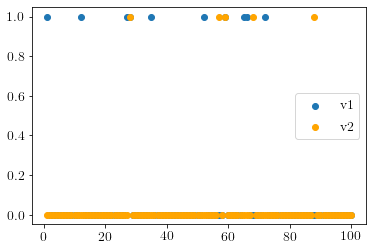

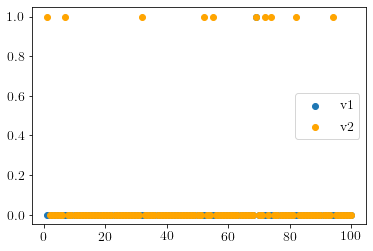

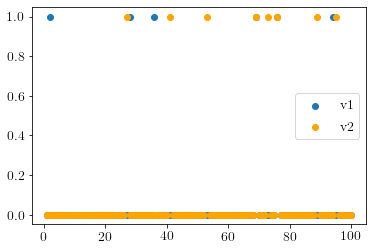

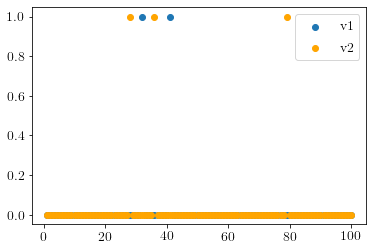

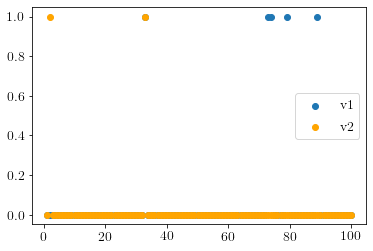

In [32]:
for i in range(Y_500_1_arrays_c.shape[1]):
    plt.figure()
    plt.scatter(seeds, Y_500_1_arrays_c[:, i], label = 'v1')
    plt.scatter(seeds, Y_500_2_arrays[:, i], label = 'v2', c = 'orange')
    plt.legend(loc = 'best')